In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 40

# Set the diffusion coefficient
sigma = 1.09

In [ ]:
print('lag time: ', lag_time)

In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 1600/1600 [00:22<00:00, 72.63it/s]


In [4]:
## Save the data to local folder
# Create a folder to store the data (if it doesn't exist)
folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

# Save the data_matrix to a file
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
np.save(file_path, data_matrix)

In [5]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(1600, 11, 2)

In [6]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[15], n_psi_train=12).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Shape of data_X: (1600, 10, 2)
Shape of data_Y: (1600, 10, 2)
Shape of X: (16000, 2)
Shape of Y: (16000, 2)
(11200, 2)
Epoch: 1 	Training Loss: 0.611203 val loss: 0.572077
saving, val loss enhanced: 0.5720773881127649 10000
Epoch: 2 	Training Loss: 0.557110 val loss: 0.521360
saving, val loss enhanced: 0.5213595705941997 0.5720773881127649
Epoch: 3 	Training Loss: 0.508554 val loss: 0.475000
saving, val loss enhanced: 0.474999551224209 0.5213595705941997
Epoch: 4 	Training Loss: 0.463507 val loss: 0.427608
saving, val loss enhanced: 0.42760795045913846 0.474999551224209
Epoch: 5 	Training Loss: 0.419468 val loss: 0.385253
saving, val loss enhanced: 0.3852525256621199 0.42760795045913846
Epoch: 6 	Training Loss: 0.376842 val loss: 0.344473
saving, val loss enhanced: 0.3444731146635286 0.3852525256621199
Epoch: 7 	Training Loss: 0.336353 val loss: 0.307292
saving, val loss enhanced: 0.30729215762271705 0.3444731146635286
Epoch: 8 	Training Loss: 0.299813 val loss: 0.271875
saving, val lo

Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3785.97iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3584.07iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 3.562412 val loss: 8.029244
saving, val loss enhanced: 8.029243604627164 1000000000000000.0
Epoch: 2 	Training Loss: 3.541475 val loss: 7.999628
saving, val loss enhanced: 7.999627827852894 8.029243604627164
Epoch: 3 	Training Loss: 3.521133 val loss: 7.970669
saving, val loss enhanced: 7.970668595223794 7.999627827852894
Epoch: 4 	Training Loss: 3.501015 val loss: 7.942084
saving, val loss enhanced: 7.942083892212312 7.970668595223794
Epoch: 5 	Training Loss: 3.481078 val loss: 7.913776
saving, val loss enhanced: 7.913776320191706 7.942083892212312
Epoch: 6 	Training Loss: 3.461306 val loss: 7.885701
saving, val loss enhanced: 7.885701433593344 7.913776320191706
Epoch: 7 	Training Loss: 3.441688 val loss: 7.857835
saving, val loss enhanced: 7.8578345435250005 7.885701433593344
Epoch: 8 	Training Loss: 3.422221 val loss: 7.830160


Computing dPsi_X: 100%|██████████| 167985/167985 [00:43<00:00, 3870.38iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 14.875677 val loss: 48.648743
Epoch: 2 	Training Loss: 14.638689 val loss: 48.214382
Epoch: 3 	Training Loss: 14.450280 val loss: 47.861751
Epoch: 4 	Training Loss: 14.291635 val loss: 47.556531
Epoch: 5 	Training Loss: 14.151835 val loss: 47.282911
Epoch: 6 	Training Loss: 14.025332 val loss: 47.032218
Epoch: 7 	Training Loss: 13.908848 val loss: 46.799082
Epoch: 8 	Training Loss: 13.800249 val loss: 46.579905
Epoch: 9 	Training Loss: 13.698053 val loss: 46.372136
Epoch: 10 	Training Loss: 13.601184 val loss: 46.173888
Epoch: 11 	Training Loss: 13.508828 val loss: 45.983723
Epoch: 12 	Training Loss: 13.420354 val loss: 45.800514
Epoch: 13 	Training Loss: 13.335262 val loss: 45.623362
Epoch: 14 	Training Loss: 13.253147 val loss: 45.451537
Epoch: 15 	Training Loss: 13.173677 val loss: 45.284437
Epoch: 16 	Training Loss: 13.096574 

Computing dPsi_X: 100%|██████████| 167985/167985 [00:50<00:00, 3355.78iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.582781 val loss: 4.740607
saving, val loss enhanced: 4.740606564161782 5.737415598700551
Epoch: 2 	Training Loss: 2.561009 val loss: 4.722871
saving, val loss enhanced: 4.722871063332674 4.740606564161782
Epoch: 3 	Training Loss: 2.540666 val loss: 4.706567
saving, val loss enhanced: 4.706566652610763 4.722871063332674
Epoch: 4 	Training Loss: 2.521832 val loss: 4.691240
saving, val loss enhanced: 4.691240085779137 4.706566652610763
Epoch: 5 	Training Loss: 2.504075 val loss: 4.676632
saving, val loss enhanced: 4.676631641505476 4.691240085779137
Epoch: 6 	Training Loss: 2.487135 val loss: 4.662581
saving, val loss enhanced: 4.662580746361639 4.676631641505476
Epoch: 7 	Training Loss: 2.470846 val loss: 4.648979
saving, val loss enhanced: 4.648978722911808 4.662580746361639
Epoch: 8 	Training Loss: 2.455091 val loss: 4.635747
sa

Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3723.92iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2.166904 val loss: 5.172900
Epoch: 2 	Training Loss: 2.158677 val loss: 5.159783
Epoch: 3 	Training Loss: 2.150732 val loss: 5.147504
Epoch: 4 	Training Loss: 2.143244 val loss: 5.135778
Epoch: 5 	Training Loss: 2.136076 val loss: 5.124435
Epoch: 6 	Training Loss: 2.129149 val loss: 5.113375
Epoch: 7 	Training Loss: 2.122412 val loss: 5.102535
Epoch: 8 	Training Loss: 2.115830 val loss: 5.091869
Epoch: 9 	Training Loss: 2.109376 val loss: 5.081346
Epoch: 10 	Training Loss: 2.103033 val loss: 5.070940
Epoch: 11 	Training Loss: 2.096783 val loss: 5.060631
Epoch: 12 	Training Loss: 2.090616 val loss: 5.050404
Epoch: 13 	Training Loss: 2.084519 val loss: 5.040245
Epoch: 14 	Training Loss: 2.078486 val loss: 5.030145
Epoch: 15 	Training Loss: 2.072508 val loss: 5.020093
Epoch: 16 	Training Loss: 2.066580 val loss: 5.010084
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3588.76iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 3.807991 val loss: 4.521384
Epoch: 2 	Training Loss: 3.735834 val loss: 4.465710
Epoch: 3 	Training Loss: 3.677346 val loss: 4.419680
Epoch: 4 	Training Loss: 3.627687 val loss: 4.379433
Epoch: 5 	Training Loss: 3.583627 val loss: 4.343130
Epoch: 6 	Training Loss: 3.543528 val loss: 4.309738
Epoch: 7 	Training Loss: 3.506424 val loss: 4.278607
Epoch: 8 	Training Loss: 3.471684 val loss: 4.249297
Epoch: 9 	Training Loss: 3.438869 val loss: 4.221489
Epoch: 10 	Training Loss: 3.407660 val loss: 4.194949
Epoch: 11 	Training Loss: 3.377813 val loss: 4.169493
Epoch: 12 	Training Loss: 3.349142 val loss: 4.144978
Epoch: 13 	Training Loss: 3.321496 val loss: 4.121290
Epoch: 14 	Training Loss: 3.294755 val loss: 4.098332
Epoch: 15 	Training Loss: 3.268818 val loss: 4.076028
Epoch: 16 	Training Loss: 3.243603 val loss: 4.054311
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:48<00:00, 3499.54iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 10.222609 val loss: 7.887288
Epoch: 2 	Training Loss: 10.083627 val loss: 7.803390
Epoch: 3 	Training Loss: 9.970788 val loss: 7.733747
Epoch: 4 	Training Loss: 9.874363 val loss: 7.672450
Epoch: 5 	Training Loss: 9.788215 val loss: 7.616793
Epoch: 6 	Training Loss: 9.709293 val loss: 7.565276
Epoch: 7 	Training Loss: 9.635811 val loss: 7.516964
Epoch: 8 	Training Loss: 9.566609 val loss: 7.471223
Epoch: 9 	Training Loss: 9.500885 val loss: 7.427601
Epoch: 10 	Training Loss: 9.438054 val loss: 7.385761
Epoch: 11 	Training Loss: 9.377674 val loss: 7.345445
Epoch: 12 	Training Loss: 9.319402 val loss: 7.306448
Epoch: 13 	Training Loss: 9.262966 val loss: 7.268607
Epoch: 14 	Training Loss: 9.208144 val loss: 7.231787
Epoch: 15 	Training Loss: 9.154754 val loss: 7.195876
Epoch: 16 	Training Loss: 9.102644 val loss: 7.160783
Epoch: 17 

Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3608.11iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 10.978499 val loss: 14.842719
Epoch: 2 	Training Loss: 10.746349 val loss: 14.627821
Epoch: 3 	Training Loss: 10.543922 val loss: 14.446789
Epoch: 4 	Training Loss: 10.366026 val loss: 14.286407
Epoch: 5 	Training Loss: 10.204650 val loss: 14.140301
Epoch: 6 	Training Loss: 10.055451 val loss: 14.004854
Epoch: 7 	Training Loss: 9.915747 val loss: 13.877764
Epoch: 8 	Training Loss: 9.783729 val loss: 13.757454
Epoch: 9 	Training Loss: 9.658106 val loss: 13.642782
Epoch: 10 	Training Loss: 9.537915 val loss: 13.532893
Epoch: 11 	Training Loss: 9.422415 val loss: 13.427124
Epoch: 12 	Training Loss: 9.311018 val loss: 13.324946
Epoch: 13 	Training Loss: 9.203251 val loss: 13.225934
Epoch: 14 	Training Loss: 9.098725 val loss: 13.129738
Epoch: 15 	Training Loss: 8.997117 val loss: 13.036065
Epoch: 16 	Training Loss: 8.898153 val loss: 

Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3643.73iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 121.840896 val loss: 96.274032
Epoch: 2 	Training Loss: 119.291358 val loss: 94.752751
Epoch: 3 	Training Loss: 117.409745 val loss: 93.557257
Epoch: 4 	Training Loss: 115.868134 val loss: 92.538502
Epoch: 5 	Training Loss: 114.527270 val loss: 91.634237
Epoch: 6 	Training Loss: 113.322637 val loss: 90.811685
Epoch: 7 	Training Loss: 112.218046 val loss: 90.051066
Epoch: 8 	Training Loss: 111.190765 val loss: 89.339362
Epoch: 9 	Training Loss: 110.225402 val loss: 88.667463
Epoch: 10 	Training Loss: 109.310965 val loss: 88.028704
Epoch: 11 	Training Loss: 108.439282 val loss: 87.418036
Epoch: 12 	Training Loss: 107.604081 val loss: 86.831528
Epoch: 13 	Training Loss: 106.800428 val loss: 86.266047
Epoch: 14 	Training Loss: 106.024360 val loss: 85.719054
Epoch: 15 	Training Loss: 105.272641 val loss: 85.188457
Epoch: 16 	Training L

Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3623.17iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 7.900944 val loss: 21.669930
Epoch: 2 	Training Loss: 7.894002 val loss: 21.657306
Epoch: 3 	Training Loss: 7.885828 val loss: 21.645043
Epoch: 4 	Training Loss: 7.877828 val loss: 21.633101
Epoch: 5 	Training Loss: 7.869969 val loss: 21.621389
Epoch: 6 	Training Loss: 7.862215 val loss: 21.609844
Epoch: 7 	Training Loss: 7.854538 val loss: 21.598420
Epoch: 8 	Training Loss: 7.846917 val loss: 21.587080
Epoch: 9 	Training Loss: 7.839335 val loss: 21.575797
Epoch: 10 	Training Loss: 7.831779 val loss: 21.564547
Epoch: 11 	Training Loss: 7.824235 val loss: 21.553312
Epoch: 12 	Training Loss: 7.816695 val loss: 21.542077
Epoch: 13 	Training Loss: 7.809150 val loss: 21.530828
Epoch: 14 	Training Loss: 7.801592 val loss: 21.519555
Epoch: 15 	Training Loss: 7.794015 val loss: 21.508247
Epoch: 16 	Training Loss: 7.786413 val loss: 21.496

Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3812.38iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 4.120240 val loss: 5.667034
Epoch: 2 	Training Loss: 4.112771 val loss: 5.661654
Epoch: 3 	Training Loss: 4.105093 val loss: 5.656198
Epoch: 4 	Training Loss: 4.097313 val loss: 5.650668
Epoch: 5 	Training Loss: 4.089430 val loss: 5.645065
Epoch: 6 	Training Loss: 4.081446 val loss: 5.639387
Epoch: 7 	Training Loss: 4.073361 val loss: 5.633635
Epoch: 8 	Training Loss: 4.065174 val loss: 5.627808
Epoch: 9 	Training Loss: 4.056884 val loss: 5.621907
Epoch: 10 	Training Loss: 4.048494 val loss: 5.615932
Epoch: 11 	Training Loss: 4.040002 val loss: 5.609881
Epoch: 12 	Training Loss: 4.031408 val loss: 5.603757
Epoch: 13 	Training Loss: 4.022713 val loss: 5.597557
Epoch: 14 	Training Loss: 4.013917 val loss: 5.591283
Epoch: 15 	Training Loss: 4.005021 val loss: 5.584935
Epoch: 16 	Training Loss: 3.996024 val loss: 5.578512
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3727.81iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 39.605413 val loss: 162.025212
Epoch: 2 	Training Loss: 38.850377 val loss: 160.513444
Epoch: 3 	Training Loss: 38.318127 val loss: 159.365068
Epoch: 4 	Training Loss: 37.887718 val loss: 158.398439
Epoch: 5 	Training Loss: 37.516352 val loss: 157.544554
Epoch: 6 	Training Loss: 37.184702 val loss: 156.768986
Epoch: 7 	Training Loss: 36.882065 val loss: 156.051657
Epoch: 8 	Training Loss: 36.601774 val loss: 155.379664
Epoch: 9 	Training Loss: 36.339343 val loss: 154.744142
Epoch: 10 	Training Loss: 36.091586 val loss: 154.138695
Epoch: 11 	Training Loss: 35.856146 val loss: 153.558533
Epoch: 12 	Training Loss: 35.631219 val loss: 152.999962
Epoch: 13 	Training Loss: 35.415391 val loss: 152.460064
Epoch: 14 	Training Loss: 35.207531 val loss: 151.936487
Epoch: 15 	Training Loss: 35.006715 val loss: 151.427304
Epoch: 16 	Training L

Computing dPsi_X: 100%|██████████| 167985/167985 [00:43<00:00, 3818.16iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 9.485677 val loss: 8.025118
Epoch: 2 	Training Loss: 9.407962 val loss: 7.971523
Epoch: 3 	Training Loss: 9.329399 val loss: 7.919984
Epoch: 4 	Training Loss: 9.253435 val loss: 7.869907
Epoch: 5 	Training Loss: 9.179343 val loss: 7.820899
Epoch: 6 	Training Loss: 9.106694 val loss: 7.772727
Epoch: 7 	Training Loss: 9.035214 val loss: 7.725233
Epoch: 8 	Training Loss: 8.964712 val loss: 7.678307
Epoch: 9 	Training Loss: 8.895047 val loss: 7.631864
Epoch: 10 	Training Loss: 8.826109 val loss: 7.585840
Epoch: 11 	Training Loss: 8.757811 val loss: 7.540182
Epoch: 12 	Training Loss: 8.690084 val loss: 7.494848
Epoch: 13 	Training Loss: 8.622869 val loss: 7.449801
Epoch: 14 	Training Loss: 8.556118 val loss: 7.405013
Epoch: 15 	Training Loss: 8.489788 val loss: 7.360457
Epoch: 16 	Training Loss: 8.423845 val loss: 7.316112
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3715.14iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 4.035685 val loss: 3.721283
Epoch: 2 	Training Loss: 4.033444 val loss: 3.719591
Epoch: 3 	Training Loss: 4.030970 val loss: 3.717875
Epoch: 4 	Training Loss: 4.028468 val loss: 3.716140
Epoch: 5 	Training Loss: 4.025940 val loss: 3.714386
Epoch: 6 	Training Loss: 4.023385 val loss: 3.712612
Epoch: 7 	Training Loss: 4.020803 val loss: 3.710820
Epoch: 8 	Training Loss: 4.018196 val loss: 3.709009
Epoch: 9 	Training Loss: 4.015561 val loss: 3.707178
Epoch: 10 	Training Loss: 4.012900 val loss: 3.705328
Epoch: 11 	Training Loss: 4.010213 val loss: 3.703459
Epoch: 12 	Training Loss: 4.007498 val loss: 3.701571
Epoch: 13 	Training Loss: 4.004758 val loss: 3.699663
Epoch: 14 	Training Loss: 4.001990 val loss: 3.697736
Epoch: 15 	Training Loss: 3.999196 val loss: 3.695790
Epoch: 16 	Training Loss: 3.996374 val loss: 3.693824
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3654.08iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.252650 val loss: 2.241084
saving, val loss enhanced: 2.2410838169348324 2.8285123045267877
Epoch: 2 	Training Loss: 1.248136 val loss: 2.236140
saving, val loss enhanced: 2.236140333035363 2.2410838169348324
Epoch: 3 	Training Loss: 1.243287 val loss: 2.231234
saving, val loss enhanced: 2.23123441622161 2.236140333035363
Epoch: 4 	Training Loss: 1.238455 val loss: 2.226373
saving, val loss enhanced: 2.226373255390415 2.23123441622161
Epoch: 5 	Training Loss: 1.233640 val loss: 2.221551
saving, val loss enhanced: 2.2215507951862556 2.226373255390415
Epoch: 6 	Training Loss: 1.228840 val loss: 2.216762
saving, val loss enhanced: 2.216762078581843 2.2215507951862556
Epoch: 7 	Training Loss: 1.224053 val loss: 2.212003
saving, val loss enhanced: 2.212003054887326 2.216762078581843
Epoch: 8 	Training Loss: 1.219277 val loss: 2.207270

Computing dPsi_X: 100%|██████████| 167985/167985 [00:48<00:00, 3469.28iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 6.035512 val loss: 5.137291
Epoch: 2 	Training Loss: 5.857102 val loss: 5.035114
Epoch: 3 	Training Loss: 5.721399 val loss: 4.953588
Epoch: 4 	Training Loss: 5.609254 val loss: 4.883553
Epoch: 5 	Training Loss: 5.511287 val loss: 4.821055
Epoch: 6 	Training Loss: 5.423045 val loss: 4.763982
Epoch: 7 	Training Loss: 5.342002 val loss: 4.711049
Epoch: 8 	Training Loss: 5.266559 val loss: 4.661405
Epoch: 9 	Training Loss: 5.195629 val loss: 4.614454
Epoch: 10 	Training Loss: 5.128432 val loss: 4.569755
Epoch: 11 	Training Loss: 5.064388 val loss: 4.526976
Epoch: 12 	Training Loss: 5.003050 val loss: 4.485858
Epoch: 13 	Training Loss: 4.944065 val loss: 4.446193
Epoch: 14 	Training Loss: 4.887151 val loss: 4.407813
Epoch: 15 	Training Loss: 4.832076 val loss: 4.370580
Epoch: 16 	Training Loss: 4.778649 val loss: 4.334377
Epoch: 17 	T

Computing dPsi_X: 100%|██████████| 167985/167985 [00:48<00:00, 3466.25iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1.842694 val loss: 2.277615
Epoch: 2 	Training Loss: 1.828189 val loss: 2.265749
Epoch: 3 	Training Loss: 1.813685 val loss: 2.254533
Epoch: 4 	Training Loss: 1.799870 val loss: 2.243736
Epoch: 5 	Training Loss: 1.786511 val loss: 2.233234
Epoch: 6 	Training Loss: 1.773484 val loss: 2.222954
Epoch: 7 	Training Loss: 1.760711 val loss: 2.212851
Epoch: 8 	Training Loss: 1.748145 val loss: 2.202894
Epoch: 9 	Training Loss: 1.735748 val loss: 2.193060
Epoch: 10 	Training Loss: 1.723495 val loss: 2.183331
Epoch: 11 	Training Loss: 1.711366 val loss: 2.173694
Epoch: 12 	Training Loss: 1.699344 val loss: 2.164137
Epoch: 13 	Training Loss: 1.687418 val loss: 2.154653
Epoch: 14 	Training Loss: 1.675576 val loss: 2.145233
Epoch: 15 	Training Loss: 1.663810 val loss: 2.135872
Epoch: 16 	Training Loss: 1.652112 val loss: 2.126565
Epoch: 17 	T

(15,)
[9.99997667e-01 9.94220058e-01 8.64994553e-01 6.25747811e-01
 5.09971834e-01 3.44311329e-01 2.94171255e-01 1.57520846e-01
 5.50778824e-02 3.22468074e-02 1.25620624e-02 5.02063114e-03
 2.99548375e-04 5.67761076e-05 1.62338354e-06]


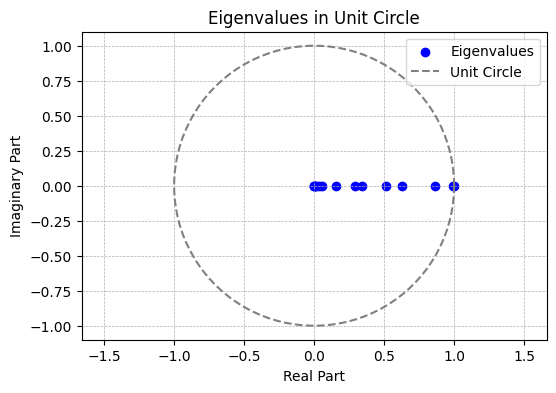

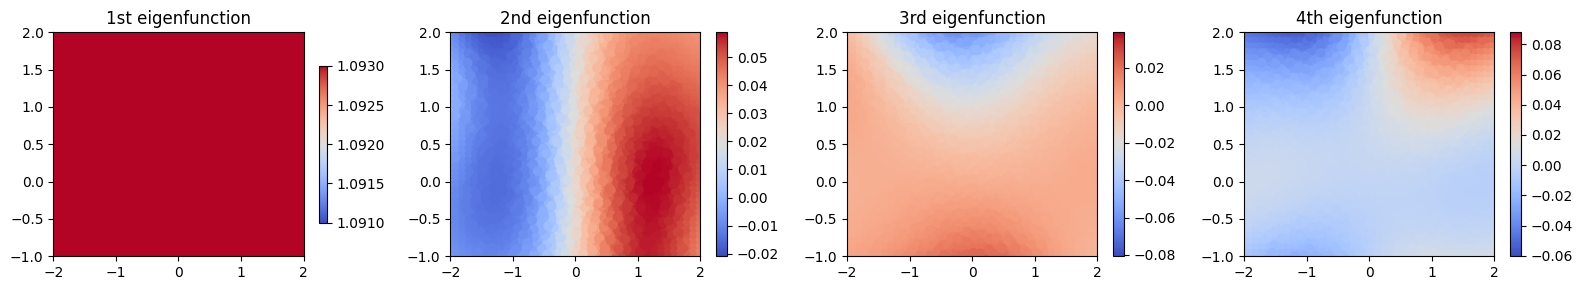

In [26]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

plt.tight_layout()
plt.show()


In [8]:
# inner epoch = 100
# training step for fnn = 200